# Benchmarking the Mixed Meal Model in Julia

In [65]:
# Base functionality
using Plots, Measures, Statistics

# ODE Solver
using DifferentialEquations

# Benchmarking
using BenchmarkTools

include("MixedMealModel.jl")

FitModelLHC (generic function with 2 methods)

## Simulation Benchmark
Below, we generate one test subject for simulation

In [56]:
sample_person = (
    fasting_glucose = 5.,
    fasting_insulin = 18.,
    fasting_triglyceride = 1.3,
    fasting_NEFA = 0.33,
    body_weight = 84.2,
    meal_glucose = 75000.,
    meal_triglyceride = 60000.
)

parameters = InitialParameters(sample_person, k1 = 0.0164, k5=0.0564, 
k6 = 2.7341, k11 = 0.00035, k12 = 0.0822, tau_LPL = 187.88, 
k14 = 0.0392, k16 = 0.0135)

constants = Constants(parameters, sample_person);

In [57]:
tspan::Tuple{Float64, Float64} = (0., 720.)
u0 = InitialValues(sample_person)
MealModel! = MixedMealModel(constants, sample_person)
System = ODEProblem(MealModel!, u0, tspan, parameters)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 720.0)
u0: 13-element Vector{Float64}:
  0.0
  5.0
  0.0
 18.0
  0.0
 18.0
 18.0
 18.0
  0.33
  0.0
  0.0
  0.0
  1.3

In [58]:
BenchmarkResult = @benchmark solve(System) samples=10_000 seconds=30

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  157.833 μs …  36.654 ms  ┊ GC (min … max): 0.00% … 99.39%
 Time  (median):     174.625 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   189.842 μs ± 655.123 μs  ┊ GC (mean ± σ):  6.88% ±  1.99%

         ▁▁ ▁▄▆█▆▆▄▂▁                                            
  ▃▄▃▂▂▆▇██▇███████████▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  158 μs           Histogram: frequency by time          227 μs <

 Memory estimate: 160.61 KiB, allocs estimate: 1030.

## Performing Parameter Estimation

In [66]:
glc, ins, trg, nfa, bwg, time = SampleData()
individual = 1

m, constants, subject = ModelFromData(glc[individual,:], ins[individual,:], trg[individual,:], nfa[individual,:], bwg[individual])
loss, simulationfunc = LossFunction(m, glc[individual,:], ins[individual,:], trg[individual,:], nfa[individual,:], Int.(time), constants, subject)
p_init = [1.35e-2, 3.80e-3, 5.82e-1, 0.00045, 0.0713, 208.88, 0.0163, 0.0119]
p_lb = [0.005, 0, 0, 0, 0, 60., 0.005, 0]
p_ub = [0.05, 1., 10., 1., 1., 720., 0.1, 1.]
println("Initial loss for individual $(individual): $(loss(p_init))")


Initial loss for individual 1: 1243.6422796132877


In [67]:

res, obj = FitModelLHC(loss, 25, p_lb, p_ub)

(Any[[0.023860387960715008, 0.02029206161519692, 3.619387760141445, 0.0006689122451417293, 0.05755746304113017, 543.6128791212798, 0.01170426290003641, 0.03410539544741438], [0.02385935965020915, 0.020292950562297355, 3.619724242924526, 0.0006689127397544593, 0.05755998954549863, 543.5853860308332, 0.011704443854995325, 0.03410582125430998], [0.020432627559038026, 0.23761755974540535, 9.999999999745356, 0.008504852836854614, 0.9594627687338452, 245.17207539684037, 0.01744923697410819, 0.40361777019617046], [0.023832496732101204, 0.020287840014787725, 3.623995404861043, 0.0006656534483734262, 0.057478671658262336, 540.7413041310534, 0.011725696238301477, 0.033996455269792794], [0.023804864032309556, 0.020282400887188714, 3.6284992323413467, 0.0006623611565864915, 0.057394179455447565, 537.9320883040631, 0.011746788487189054, 0.0338834297126358], [0.023760531495335396, 0.020275758150187458, 3.635799083106717, 0.0006570259156836954, 0.05726829267200184, 533.2920731889961, 0.01178252232244

In [68]:
obj

25-element Vector{Float64}:
   5.052092202020065
   5.052091113460918
 212.27753852330636
   5.052933282912351
   5.055446233894082
   5.0632839246324854
 240.38312415231871
   5.052092041357447
   5.052091996586427
   5.060564542654685
   ⋮
   5.052818547291215
   5.053693830525134
   5.053246790596873
   5.052090440741665
   5.052365873138017
   5.052092031307693
 195.3777606653192
   5.05209310699155
   5.052091418140593

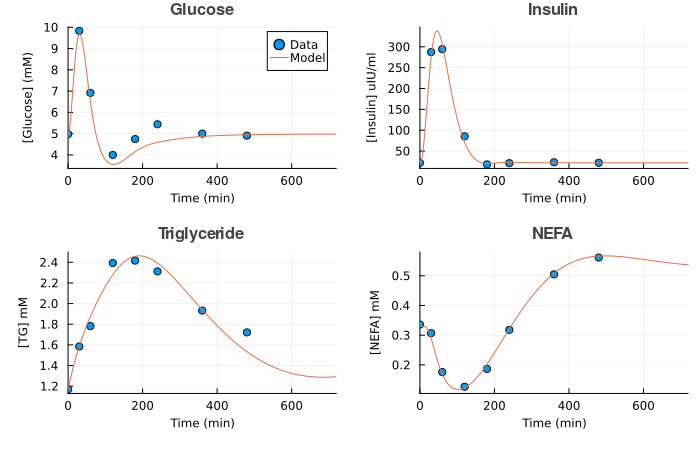

In [71]:
outputs = simulationfunc(res[argmin(obj),:][1])

glucose_data_plot = scatter(time, glc[individual,:], title="Glucose", labels="Data", ylabel = "[Glucose] (mM)")
plot!(glucose_data_plot, outputs, idxs=2, label="Model")
insulin_data_plot = scatter(time, ins[individual,:], title="Insulin", ylabel = "[Insulin] uIU/ml", labels="")
plot!(insulin_data_plot, outputs, idxs=4, label="")
TG_data_plot = scatter(time, trg[individual,:], title="Triglyceride", ylabel = "[TG] mM", labels="")
plot!(TG_data_plot, outputs, idxs=13, label="")
NEFA_data_plot = scatter(time, nfa[individual,:], title="NEFA", ylabel = "[NEFA] mM", labels="")
plot!(NEFA_data_plot, outputs, idxs=9, label="")


plot(glucose_data_plot, insulin_data_plot, TG_data_plot, NEFA_data_plot, layout=4, titlefontfamily="Helvetica Bold", titlefontsize=11, xlabel="Time (min)", labelfontsize=8, size=(700,450), left_margin=5mm, bottom_margin=5mm)

